In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import warnings
import os
from pathlib import Path
warnings.filterwarnings('ignore')

In [15]:
# ============================================================================
# SETUP: DIRETÓRIO E PASTAS
# ============================================================================

# Se estiver em notebooks/, suba para raiz
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
    print(f"Mudando para: {os.getcwd()}")

# Criar pastas
Path('outputs/plots').mkdir(parents=True, exist_ok=True)
Path('outputs/reports').mkdir(parents=True, exist_ok=True)
Path('data/processed').mkdir(parents=True, exist_ok=True)

print(f"Working directory: {os.getcwd()}\n")

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)


Working directory: /home/maricarminate/Projetos/anomaly-detector



In [16]:
# ============================================================================
# CARREGAR DADOS
# ============================================================================

print("=" * 70)
print("DIA 3: MÉTODOS BASEADOS EM ÁRVORES E DISTÂNCIA")
print("=" * 70)

train = pd.read_csv('data/processed/nyc_taxi_train.csv', parse_dates=['timestamp'])
test = pd.read_csv('data/processed/nyc_taxi_test.csv', parse_dates=['timestamp'])

print(f"\nDados carregados:")
print(f"  Treino: {len(train)} pontos")
print(f"  Teste: {len(test)} pontos")

DIA 3: MÉTODOS BASEADOS EM ÁRVORES E DISTÂNCIA

Dados carregados:
  Treino: 3494 pontos
  Teste: 874 pontos


In [17]:
# ============================================================================
# PREPARAR DADOS: SLIDING WINDOW (FEATURE ENGINEERING)
# ============================================================================

def create_features(data, window_size=24):
    """
    Cria features a partir da série temporal usando sliding window.
    
    Para cada ponto, cria features baseadas nos últimos 'window_size' pontos.
    Isso transforma a série temporal em um dataset de features.
    """
    features = []
    for i in range(window_size, len(data)):
        window = data.iloc[i-window_size:i]['value'].values
        features.append({
            'mean': np.mean(window),
            'std': np.std(window),
            'min': np.min(window),
            'max': np.max(window),
            'range': np.max(window) - np.min(window),
            'current_value': data.iloc[i]['value']
        })
    return pd.DataFrame(features)

print("\nCriando features (sliding window com janela de 24 horas)...")
train_features = create_features(train, window_size=24)
test_features = create_features(test, window_size=24)

print(f"  Train features: {train_features.shape}")
print(f"  Test features: {test_features.shape}")

# Normalizar
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

print("✓ Features normalizadas com StandardScaler")



Criando features (sliding window com janela de 24 horas)...
  Train features: (3470, 6)
  Test features: (850, 6)
✓ Features normalizadas com StandardScaler


In [18]:
# ============================================================================
# MÉTODO 1: ISOLATION FOREST
# ============================================================================

print("\n" + "=" * 70)
print("MÉTODO 1: ISOLATION FOREST")
print("=" * 70)

"""
Isolation Forest é baseado em árvores de decisão aleatórias.

Lógica:
- Isola anomalias particionando aleatoriamente features
- Anomalias são isoladas mais rapidamente (menos divisões necessárias)
- Pontos normais precisam de mais divisões
- Outputs: anomaly scores e labels

Parâmetros:
- contamination: proporção esperada de anomalias (0.05 = 5%)
- random_state: reproducibilidade
"""

iso_forest = IsolationForest(
    contamination=0.05,  # Esperamos ~5% de anomalias
    random_state=42,
    n_estimators=100
)

iso_forest.fit(train_features_scaled)
iso_pred = iso_forest.predict(test_features_scaled)
iso_scores = iso_forest.score_samples(test_features_scaled)

# Converter predições: -1 = anomalia, 1 = normal
iso_predictions = (iso_pred == -1).astype(int)
anomalies_iso = test.iloc[24:24+len(test_features)][iso_predictions == 1].copy()

print(f"\nParâmetros:")
print(f"  Contamination: 5%")
print(f"  N estimators: 100")
print(f"  Window size: 24 horas")
print(f"\nAnomalias detectadas: {iso_predictions.sum()} ({100*iso_predictions.sum()/len(iso_predictions):.2f}%)")
print(f"Anomaly scores: min={iso_scores.min():.4f}, max={iso_scores.max():.4f}")


MÉTODO 1: ISOLATION FOREST

Parâmetros:
  Contamination: 5%
  N estimators: 100
  Window size: 24 horas

Anomalias detectadas: 130 (15.29%)
Anomaly scores: min=-0.6752, max=-0.3677


In [19]:
# ============================================================================
# MÉTODO 2: LOCAL OUTLIER FACTOR (LOF)
# ============================================================================

print("\n" + "=" * 70)
print("MÉTODO 2: LOCAL OUTLIER FACTOR (LOF)")
print("=" * 70)

"""
LOF detecta anomalias pela densidade local de pontos.

Lógica:
- Calcula densidade local de cada ponto
- Anomalias têm densidade local muito menor que vizinhos
- Bom para detectar anomalias "locais" (diferentes do contexto imediato)

Parâmetros:
- n_neighbors: quantos vizinhos considerar (padrão: 20)
- contamination: proporção esperada de anomalias
"""

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05
)

lof_pred = lof.fit_predict(test_features_scaled)
lof_scores = lof.negative_outlier_factor_

# Converter predições
lof_predictions = (lof_pred == -1).astype(int)
anomalies_lof = test.iloc[24:24+len(test_features)][lof_predictions == 1].copy()

print(f"\nParâmetros:")
print(f"  N neighbors: 20")
print(f"  Contamination: 5%")
print(f"  Window size: 24 horas")
print(f"\nAnomalias detectadas: {lof_predictions.sum()} ({100*lof_predictions.sum()/len(lof_predictions):.2f}%)")
print(f"LOF scores: min={lof_scores.min():.4f}, max={lof_scores.max():.4f}")



MÉTODO 2: LOCAL OUTLIER FACTOR (LOF)

Parâmetros:
  N neighbors: 20
  Contamination: 5%
  Window size: 24 horas

Anomalias detectadas: 43 (5.06%)
LOF scores: min=-1.6982, max=-0.9617


In [20]:
# ============================================================================
# MÉTODO 3: DBSCAN
# ============================================================================

print("\n" + "=" * 70)
print("MÉTODO 3: DBSCAN (DENSITY-BASED SPATIAL CLUSTERING)")
print("=" * 70)

"""
DBSCAN agrupa pontos por densidade e marca outliers.

Lógica:
- Particiona dados em clusters densos
- Pontos não no clusters são outliers
- eps: raio máximo de vizinhança
- min_samples: mínimo de pontos pra formar cluster

Parâmetros:
- eps: distância máxima entre pontos (ajuste por validação)
- min_samples: mínimo de vizinhos (padrão: 5)
"""

dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_pred = dbscan.fit_predict(test_features_scaled)

# Em DBSCAN: -1 = outlier (anomalia), >= 0 = cluster
dbscan_predictions = (dbscan_pred == -1).astype(int)
anomalies_dbscan = test.iloc[24:24+len(test_features)][dbscan_predictions == 1].copy()

n_clusters = len(set(dbscan_pred)) - (1 if -1 in dbscan_pred else 0)

print(f"\nParâmetros:")
print(f"  eps: 1.5")
print(f"  min_samples: 5")
print(f"  Window size: 24 horas")
print(f"\nClusters encontrados: {n_clusters}")
print(f"Anomalias detectadas: {dbscan_predictions.sum()} ({100*dbscan_predictions.sum()/len(dbscan_predictions):.2f}%)")



MÉTODO 3: DBSCAN (DENSITY-BASED SPATIAL CLUSTERING)

Parâmetros:
  eps: 1.5
  min_samples: 5
  Window size: 24 horas

Clusters encontrados: 1
Anomalias detectadas: 0 (0.00%)



GERANDO VISUALIZAÇÕES
✓ Salvo: outputs/plots/03_tree_methods.png


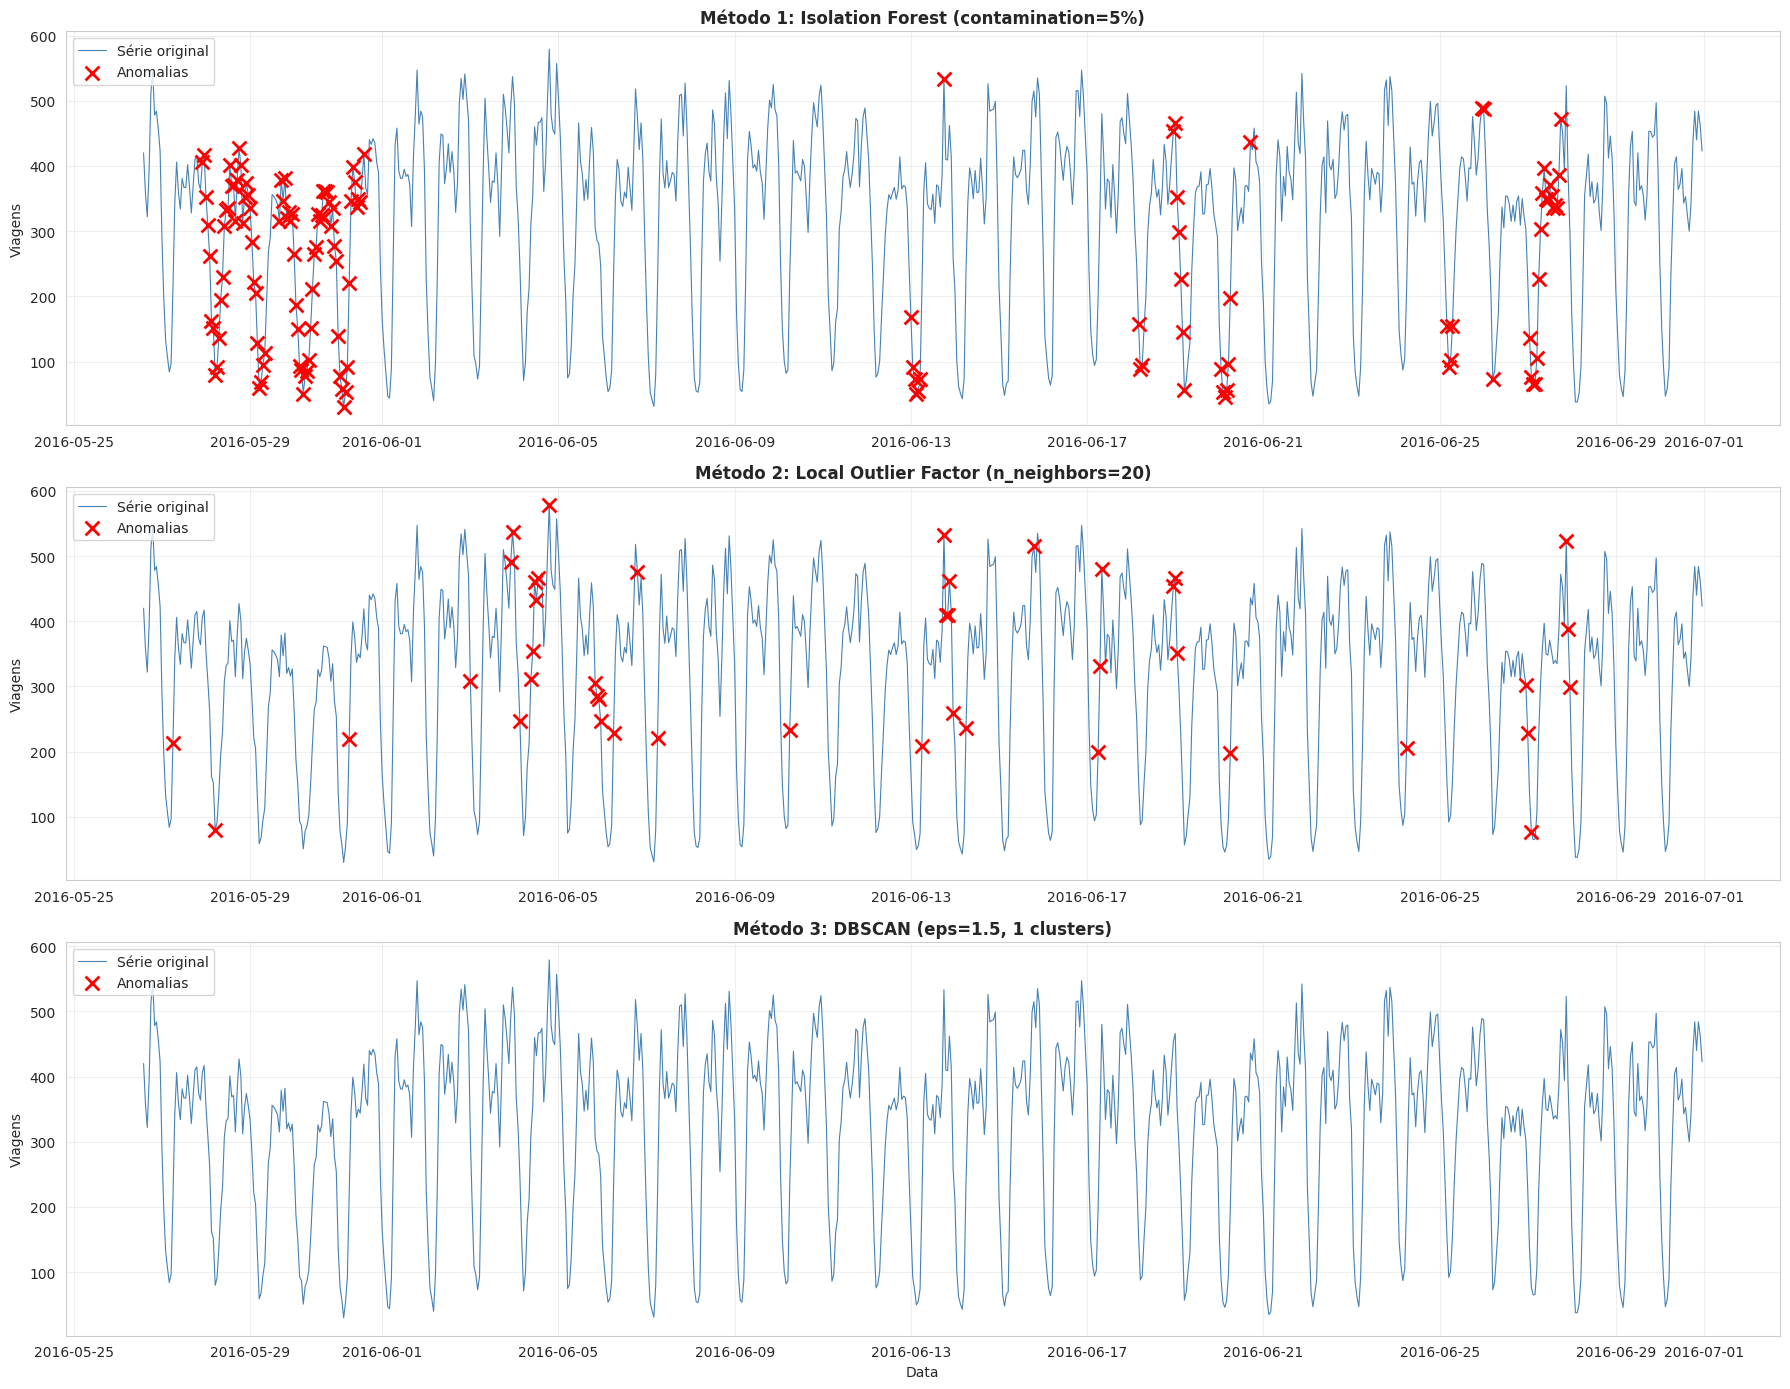

In [21]:
# ============================================================================
# VISUALIZAÇÕES COMPARATIVAS
# ============================================================================

print("\n" + "=" * 70)
print("GERANDO VISUALIZAÇÕES")
print("=" * 70)

# Ajustar índices para alinhar com teste (depois da janela)
test_aligned = test.iloc[24:24+len(test_features)].reset_index(drop=True)

fig, axes = plt.subplots(3, 1, figsize=(18, 14))

# MÉTODO 1: Isolation Forest
axes[0].plot(test_aligned['timestamp'], test_aligned['value'], 
            label='Série original', linewidth=0.8, color='steelblue')
axes[0].scatter(anomalies_iso['timestamp'], anomalies_iso['value'], 
               color='red', s=100, marker='x', linewidth=2, label='Anomalias', zorder=5)
axes[0].set_title('Método 1: Isolation Forest (contamination=5%)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Viagens')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# MÉTODO 2: LOF
axes[1].plot(test_aligned['timestamp'], test_aligned['value'], 
            label='Série original', linewidth=0.8, color='steelblue')
axes[1].scatter(anomalies_lof['timestamp'], anomalies_lof['value'], 
               color='red', s=100, marker='x', linewidth=2, label='Anomalias', zorder=5)
axes[1].set_title('Método 2: Local Outlier Factor (n_neighbors=20)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Viagens')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# MÉTODO 3: DBSCAN
axes[2].plot(test_aligned['timestamp'], test_aligned['value'], 
            label='Série original', linewidth=0.8, color='steelblue')
axes[2].scatter(anomalies_dbscan['timestamp'], anomalies_dbscan['value'], 
               color='red', s=100, marker='x', linewidth=2, label='Anomalias', zorder=5)
axes[2].set_title(f'Método 3: DBSCAN (eps=1.5, {n_clusters} clusters)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Viagens')
axes[2].set_xlabel('Data')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/plots/03_tree_methods.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/03_tree_methods.png")
plt.show()

In [22]:
# ============================================================================
# TABELA COMPARATIVA
# ============================================================================

print("\n" + "=" * 70)
print("COMPARAÇÃO ENTRE MÉTODOS")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Método': ['Isolation Forest', 'LOF', 'DBSCAN'],
    'Anomalias Detectadas': [
        iso_predictions.sum(),
        lof_predictions.sum(),
        dbscan_predictions.sum()
    ],
    'Percentual': [
        f"{100*iso_predictions.sum()/len(iso_predictions):.2f}%",
        f"{100*lof_predictions.sum()/len(lof_predictions):.2f}%",
        f"{100*dbscan_predictions.sum()/len(dbscan_predictions):.2f}%"
    ],
    'Tipo': ['Árvores', 'Densidade', 'Clustering'],
    'Complexidade': ['O(n log n)', 'O(n²)', 'O(n²)']
})

print("\n" + comparison_df.to_string(index=False))


COMPARAÇÃO ENTRE MÉTODOS

          Método  Anomalias Detectadas Percentual       Tipo Complexidade
Isolation Forest                   130     15.29%    Árvores   O(n log n)
             LOF                    43      5.06%  Densidade        O(n²)
          DBSCAN                     0      0.00% Clustering        O(n²)


In [23]:
# ============================================================================
# ANÁLISE DE SOBREPOSIÇÃO
# ============================================================================

print("\n" + "=" * 70)
print("ANÁLISE DE SOBREPOSIÇÃO DE ANOMALIAS")
print("=" * 70)

anomaly_matrix = pd.DataFrame({
    'ISO_FOREST': iso_predictions,
    'LOF': lof_predictions,
    'DBSCAN': dbscan_predictions
})

anomaly_matrix['consensus'] = anomaly_matrix.sum(axis=1)

print(f"\nDistribuição de consenso:")
print(anomaly_matrix['consensus'].value_counts().sort_index(ascending=False))

# Anomalias detectadas por todos os 3 métodos
all_agree = anomaly_matrix[anomaly_matrix['consensus'] == 3]
print(f"\nAnomalias detectadas por TODOS os 3 métodos: {len(all_agree)}")



ANÁLISE DE SOBREPOSIÇÃO DE ANOMALIAS

Distribuição de consenso:
consensus
2      8
1    157
0    685
Name: count, dtype: int64

Anomalias detectadas por TODOS os 3 métodos: 0


✓ Salvo: outputs/plots/03_feature_space.png


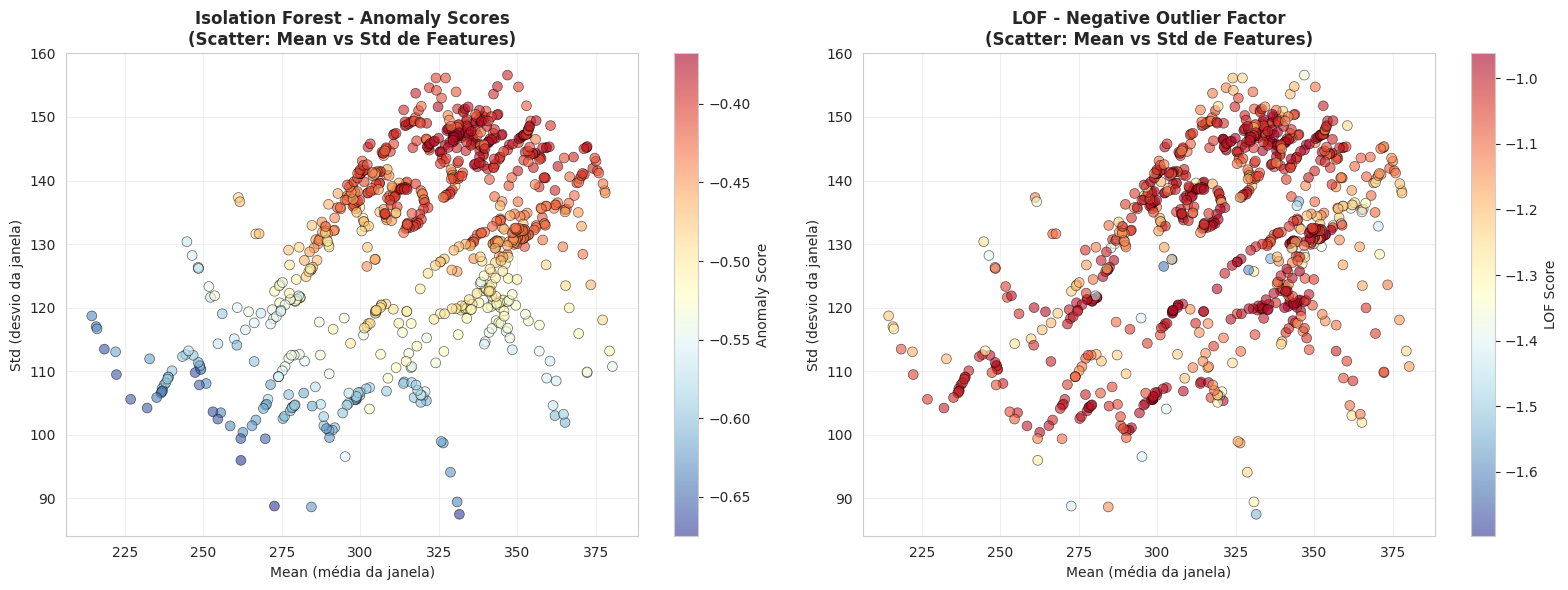

In [24]:
# ============================================================================
# SCATTER PLOT NO ESPAÇO DE FEATURES
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Isolation Forest scores
scatter1 = axes[0].scatter(test_features['mean'], test_features['std'], 
                          c=iso_scores, cmap='RdYlBu_r', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].set_title('Isolation Forest - Anomaly Scores\n(Scatter: Mean vs Std de Features)', 
                 fontsize=12, fontweight='bold')
axes[0].set_xlabel('Mean (média da janela)')
axes[0].set_ylabel('Std (desvio da janela)')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Anomaly Score')
axes[0].grid(True, alpha=0.3)

# LOF scores
scatter2 = axes[1].scatter(test_features['mean'], test_features['std'], 
                          c=lof_scores, cmap='RdYlBu_r', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].set_title('LOF - Negative Outlier Factor\n(Scatter: Mean vs Std de Features)', 
                 fontsize=12, fontweight='bold')
axes[1].set_xlabel('Mean (média da janela)')
axes[1].set_ylabel('Std (desvio da janela)')
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('LOF Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/plots/03_feature_space.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/03_feature_space.png")
plt.show()

In [25]:
# ============================================================================
# SALVAR RESULTADOS
# ============================================================================

results_df = test_aligned.copy()
results_df['iso_forest_pred'] = iso_predictions
results_df['iso_forest_score'] = iso_scores
results_df['lof_pred'] = lof_predictions
results_df['lof_score'] = lof_scores
results_df['dbscan_pred'] = dbscan_predictions
results_df['consensus'] = anomaly_matrix['consensus'].values

results_df.to_csv('outputs/reports/day3_tree_methods_results.csv', index=False)
print("\n✓ Resultados salvos: outputs/reports/day3_tree_methods_results.csv")



✓ Resultados salvos: outputs/reports/day3_tree_methods_results.csv


In [26]:
# ============================================================================
# SUMMARY E RECOMENDAÇÕES
# ============================================================================

print("\n" + "=" * 70)
print("RESUMO E RECOMENDAÇÕES")
print("=" * 70)

print("\n📊 ISOLATION FOREST:")
print("  ✓ Rápido e escalável")
print("  ✓ Bom para outliers globais")
print("  ✗ Menos efetivo com dados de alta dimensionalidade")

print("\n📊 LOCAL OUTLIER FACTOR:")
print("  ✓ Detecta anomalias 'locais' (contexto)")
print("  ✓ Bom para dados com diferentes densidades")
print("  ✗ Mais lento em datasets grandes")

print("\n📊 DBSCAN:")
print("  ✓ Encontra clusters automaticamente")
print("  ✓ Robusto para outliers naturais")
print("  ✗ Sensível aos parâmetros eps e min_samples")

print("\n" + "=" * 70)
print("DIA 3 CONCLUÍDO!")
print("=" * 70)
print("\nPróximos passos:")
print("  - Comparar resultados dos 3 métodos")
print("  - Ajustar hiperparâmetros se necessário")
print("  - Dia 4: Deep Learning com Autoencoders")


RESUMO E RECOMENDAÇÕES

📊 ISOLATION FOREST:
  ✓ Rápido e escalável
  ✓ Bom para outliers globais
  ✗ Menos efetivo com dados de alta dimensionalidade

📊 LOCAL OUTLIER FACTOR:
  ✓ Detecta anomalias 'locais' (contexto)
  ✓ Bom para dados com diferentes densidades
  ✗ Mais lento em datasets grandes

📊 DBSCAN:
  ✓ Encontra clusters automaticamente
  ✓ Robusto para outliers naturais
  ✗ Sensível aos parâmetros eps e min_samples

DIA 3 CONCLUÍDO!

Próximos passos:
  - Comparar resultados dos 3 métodos
  - Ajustar hiperparâmetros se necessário
  - Dia 4: Deep Learning com Autoencoders
